# Functions

In [8]:
import numpy as np
import string
import matplotlib.pyplot as plt
import pandas as pd
from mlcolvar.utils.io import load_dataframe
from mlcolvar.utils.fes import compute_fes
from mlcolvar.utils.plot import plot_metrics
from matplotlib.lines import Line2D

def load_colvar(file, cv_name=None, start=0, stop=-1):
    with open(file, 'r') as f:
        for line in f:
            if line.startswith('#! FIELDS'):
                header = line.strip().split()[2:]  # Skip "#! FIELDS"
                break
    for i in range(len(header)):
        if header[i] == cv_name:
            column_idx = i
            break
    data = np.loadtxt(file)
    time = data[start:stop, 0]
    cv = data[start:stop, column_idx]
    return time, cv

def fes_1D(files, ranges=None, cv_name=None, bias='opes.bias', temp=298, bandwidth=0.05):
    df_list = []
    if ranges == None:
        for file in files:
            df_tmp = load_dataframe(file)
            df_list.append(df_tmp)
    else:
        for file, range in zip(files, ranges):
            df_tmp = load_dataframe(file, start=range[0], stop=range[1])
            print(range[0], range[1])
            df_list.append(df_tmp)
    df = pd.concat(df_list, ignore_index=True)

    X = df.filter(regex=cv_name).values
    if bias == None:
        weights = None
    else:
        bias = df.filter(regex=bias).values.flatten()
        kb=0.008314
        beta=1./(kb*temp)
        logweights = beta * bias
        weights = np.exp(logweights)

    fes, bins, bounds, error = compute_fes(
        X=X,  # Use the 1D TICA CV
        temp=temp,   # System temperature
        num_samples=100,  # Grid resolution
        bandwidth=bandwidth,   # KDE bandwidth
        #scale_by="range",
        kernel="gaussian",  # Kernel type for density estimation
        backend="sklearn",
        weights=weights, 
        fes_to_zero=None,  # Shift minimum FES to zero
        plot=False,  # Automatically plot the FES
        blocks=1,
        #eps=1e-6
    )

    return fes, bins, bounds, error

def fes_2D(file_1, file_2, file_bias, 
           cv_name_1=None, cv_name_2=None, 
           range=None, bias='opes.bias', temp=298, bandwidth=0.05):
    if range == None:
        df_1 = load_dataframe(file_1)
        df_2 = load_dataframe(file_2)
        df_bias = load_dataframe(file_bias)
    else:
        df_1 = load_dataframe(file_1, start=range[0], stop=range[1])
        df_2 = load_dataframe(file_2, start=range[0], stop=range[1])
        df_bias = load_dataframe(file_bias, start=range[0], stop=range[1])
    cv_1 = df_1.filter(regex=cv_name_1).values
    cv_2 = df_2.filter(regex=cv_name_2).values
    X = np.column_stack((cv_1.ravel(), cv_2.ravel()))
    if bias == None:
        weights = None
    else:
        biases = df_bias.filter(regex=bias).values.flatten()
        kb=0.008314
        beta=1./(kb*temp)
        logweights = beta * biases
        weights = np.exp(logweights)
    fes, bins, bounds, error = compute_fes(
        X=X,  # Use the 2D CV
        temp=temp,   # System temperature
        num_samples=100,  # Grid resolution
        bandwidth=bandwidth,   # KDE bandwidth
        #scale_by="range",
        kernel="gaussian",  # Kernel type for density estimation
        backend="sklearn",
        weights=weights, 
        fes_to_zero=None,  # Shift minimum FES to zero
        plot=False,  # Automatically plot the FES
        blocks=1,
        #eps=1e-6
    )
    return fes, bins, bounds, error

# A contact map CV drives folding transitions but fails to recover thermodynamics

In [76]:
# Free energy calculation
files = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational/conf0_1/COLVAR",
         "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational/conf1_1/COLVAR",
         "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational/conf2_2/COLVAR"]
fes_wt_0, bins_wt_0, bounds_wt_0, error_wt_0 = fes_1D([files[0]], ranges=[(25000, -1)], cv_name="native", bias="metad.rbias", bandwidth=9.724786)
fes_wt_1, bins_wt_1, bounds_wt_1, error_wt_1 = fes_1D([files[1]], ranges=[(20000, -1)], cv_name="native", bias="metad.rbias", bandwidth=9.042349)
fes_wt_2, bins_wt_2, bounds_wt_2, error_wt_2 = fes_1D([files[2]], ranges=[(20000, -1)], cv_name="native", bias="metad.rbias", bandwidth=7.248465)

25000 -1
20000 -1
20000 -1


0.746681 0.999923
0.020801 0.170863


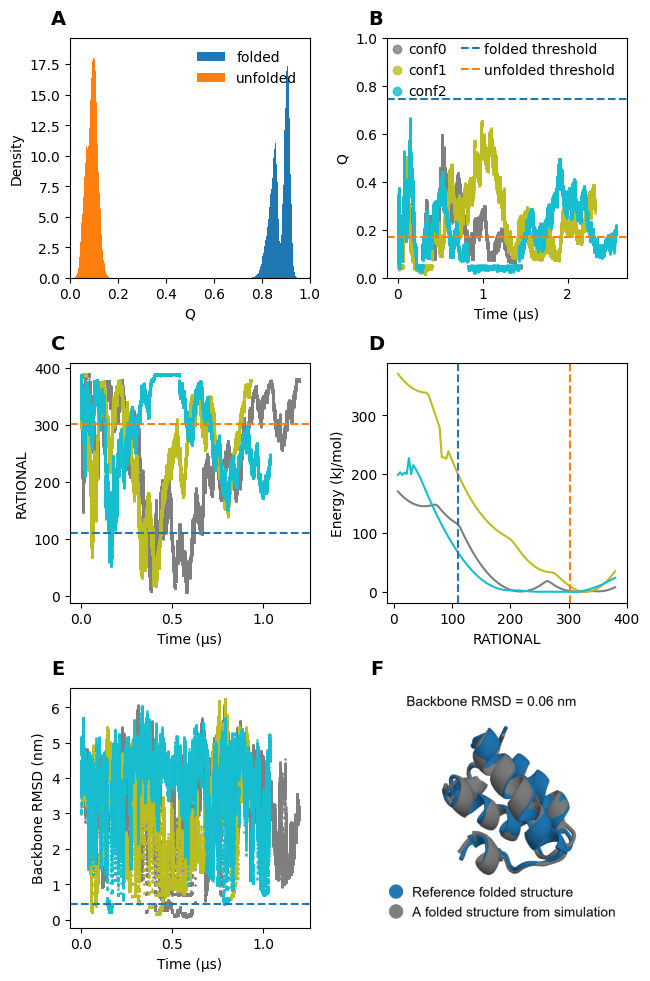

In [77]:
# Initialise the plot
fig, ax = plt.subplots(3, 2, figsize=(6.6, 9.9))

########################
# CV distribution of Q #
########################
files_a = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/folded/COLVARS/COLVAR_native",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/unfolded/COLVARS/COLVAR_native"]
labels_a = ["folded", "unfolded"]
colors_a = ["C0", "C1"]

for file, label, color in zip(files_a, labels_a, colors_a):
    time, cv = load_colvar(file, "native", start=0, )#stop=50000)
    print(np.min(cv), np.max(cv))
    ax[0,0].hist(cv, alpha=1, label=label, bins=100, density=True, color=color)
ax[0,0].set_xlim(0, 1.0)
ax[0,0].set_xlabel("Q")
ax[0,0].set_ylabel("Density")
ax[0,0].legend(loc="upper right", frameon=False)

#####
# Q #
#####
files_b = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/control/conf0/interval_0.05_0.95/COLVAR",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/control/conf1/interval_0.05_0.95/COLVAR",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/control/conf2/interval_0.05_0.95/COLVAR"]
labels_b = ["conf0", "conf1", "conf2"]
#colors_b = ["#2f2f2f","#888c86","#dcd6ba"]
colors_b = ["C7","C8","C9"]

for file, label, color in zip(files_b, labels_b, colors_b):
    time, cv = load_colvar(file, "native", start=0, )#stop=50000)
    time = time / 1000000   # Convert ps to µs
    ax[0,1].scatter(time, cv, alpha=0.8, label=label, s=1, color=color)

ax[0,1].axhline(0.746681, color='C0', linestyle='--', label='folded threshold')
ax[0,1].axhline(0.170863, color='C1', linestyle='--', label='unfolded threshold')
ax[0,1].set_ylim(0, 1.0)
ax[0,1].set_xlabel("Time (µs)")
ax[0,1].set_ylabel("Q")
ax[0,1].legend(loc="upper right", 
               bbox_to_anchor=(1.0, 1.035),  # (x, y): move y from 1.0 to 1.05
               frameon=False, 
               ncol=2, 
               handletextpad=0.1,  # reduce space between marker and text
               columnspacing=1.0,
               handlelength=1.5,
               markerscale=6
               )

#################################
# Time evolution of RATIONAL CV #
#################################
files_b = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational/conf0_1/COLVAR",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational/conf1_1/COLVAR",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational/conf2_2/COLVAR"]
labels_b = ["conf0", "conf1", "conf2"]

for file, label, color in zip(files_b, labels_b, colors_b):
    time, cv = load_colvar(file, "native", start=0, )#stop=50000)
    time = time / 1000000   # Convert ps to µs
    ax[1,0].scatter(time, cv, alpha=0.8, label=label, s=1, color=color)

ax[1,0].axhline(109.533825, color='C0', linestyle='--', label='folded threshold')
ax[1,0].axhline(301.900249, color='C1', linestyle='--', label='unfolded threshold')
#ax[1,0].set_ylim(0, 1.0)
ax[1,0].set_xlabel("Time (µs)")
ax[1,0].set_ylabel("RATIONAL")
'''
ax[1,0].legend(loc="upper right", 
               frameon=False, 
               ncol=2, 
               handletextpad=0.1,  # reduce space between marker and text
               columnspacing=1.0,
               handlelength=1.5,
               )
'''
###################################
# Time evolution of backbone RMSD #
###################################
files_rmsd = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational/conf0_1/rmsd_from_native.xvg", 
              "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational/conf1_1/rmsd_from_native.xvg",
              "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational/conf2_2/rmsd_from_native.xvg"
              ]
for file, label, color in zip(files_rmsd, labels_b, colors_b):
    time, rmsd = np.genfromtxt(file, skip_header=18, unpack=True)
    time = time / 1000000   # Convert ps to µs
    ax[2,0].scatter(time, rmsd, alpha=0.8, label=label, s=1, color=color)
ax[2,0].axhline(0.4532633, color='C0', linestyle='--', label='Folded threshold')
#ax[1].axhline(1.0413946, color='darkmagenta', linestyle='--', label='Unfolded threshold')
ax[2,0].set_xlabel("Time (µs)", )#fontsize=16)
ax[2,0].set_ylabel("Backbone RMSD (nm)", )#ontsize=16)

#######################
# Free energy profile #
#######################
ax[1,1].plot(bins_wt_0, fes_wt_0, label="bias exchange unbiased", color=colors_b[0])
ax[1,1].plot(bins_wt_0, fes_wt_1, label="bias exchange opes", color=colors_b[1])
#ax[0,1].set_yticks((0,30,60,90))
ax[1,1].plot(bins_wt_0, fes_wt_2, label="bias exchange opesE", color=colors_b[2])
ax[1,1].set_xlabel("RATIONAL", )#fontsize=16)
ax[1,1].set_ylabel("Energy (kJ/mol)", )#fontsize=16)
ax[1,1].axvline(109.533825, color='C0', linestyle='--', label='Folded threshold')
ax[1,1].axvline(301.900249, color='C1', linestyle='--', label='Unfolded threshold')
ax[1,1].set_xticks((0,100,200,300,400))
ax[1,1].tick_params(labelbottom=True)

########################
# Structure comparason #
########################
ax[2,1].axis('off')
from PIL import Image
fig1_f = "D:/Documents/Zhao/MRes/Thesis/Figures/fig1_f.png"
img = Image.open(fig1_f)
ax[2,1].imshow(img)


for ax_panel, panel_label in zip(ax.flat, ["A", "B", "C", "D", "E", "F"]):
    ax_panel.text(
        -0.08, 1.12,            # x, y in axes‐fraction (0=left/bottom, 1=right/top)
        panel_label,           # the letter
        transform=ax_panel.transAxes,
        fontsize=14,
        fontweight='bold',
        va='top',
        ha='left',
    )
    ax_panel.set_facecolor((0, 0, 0, 0))    # Axes background transparent
fig.patch.set_alpha(0)            # Figure background

fig.tight_layout()

# Machine learning methods

In [1]:
import torch
from mlcolvar.utils.io import create_dataset_from_files

lda_model = "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/deeplda_cvs/model_10011.ptc"
feature_files = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/folded/COLVARS/COLVAR_ca_sc",
                 "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/unfolded/COLVARS/COLVAR_ca_sc"]

model = torch.load(lda_model)
model.eval()

dataset, df = create_dataset_from_files(feature_files,return_dataframe=True)
X = dataset[:]['data']
labels = dataset[:]['labels']

with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()
folded_cv = s[labels == 0, 0]  # CV for folded state
unfolded_cv = s[labels == 1, 0]  # CV for unfolded state

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\serialization.py:1007: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


Class 0 dataframe shape:  (120001, 10014)
Class 1 dataframe shape:  (50001, 10014)

 - Loaded dataframe (170002, 10014): ['time', 'd_CA_1_MET_CENTROID_1_MET', 'd_CA_1_MET_CA_2_GLU', 'd_CA_1_MET_CENTROID_2_GLU', 'd_CA_1_MET_CA_3_TYR', 'd_CA_1_MET_CENTROID_3_TYR', 'd_CA_1_MET_CA_4_GLN', 'd_CA_1_MET_CENTROID_4_GLN', 'd_CA_1_MET_CA_5_HIS', 'd_CA_1_MET_CENTROID_5_HIS', 'd_CA_1_MET_CA_6_TRP', 'd_CA_1_MET_CENTROID_6_TRP', 'd_CA_1_MET_CA_7_LEU', 'd_CA_1_MET_CENTROID_7_LEU', 'd_CA_1_MET_CA_8_ARG', 'd_CA_1_MET_CENTROID_8_ARG', 'd_CA_1_MET_CA_9_GLU', 'd_CA_1_MET_CENTROID_9_GLU', 'd_CA_1_MET_CA_10_ALA', 'd_CA_1_MET_CENTROID_10_ALA', 'd_CA_1_MET_CA_11_ILE', 'd_CA_1_MET_CENTROID_11_ILE', 'd_CA_1_MET_CA_12_SER', 'd_CA_1_MET_CENTROID_12_SER', 'd_CA_1_MET_CA_13_GLN', 'd_CA_1_MET_CENTROID_13_GLN', 'd_CA_1_MET_CA_14_LEU', 'd_CA_1_MET_CENTROID_14_LEU', 'd_CA_1_MET_CA_15_GLN', 'd_CA_1_MET_CENTROID_15_GLN', 'd_CA_1_MET_CA_16_ALA', 'd_CA_1_MET_CENTROID_16_ALA', 'd_CA_1_MET_CA_17_SER', 'd_CA_1_MET_CENTROID_17

In [27]:
import numpy as np
# Getting importance scores from the model
X_np = X.detach().numpy()
weights = model.state_dict()['nn.nn.0.weight'].cpu().numpy()
feature_stds = np.std(X_np, axis=0)
importance = np.sum(np.abs(weights), axis=0) * feature_stds
feature_indices = np.argsort(-importance)   # Sorting features by importance

with open(feature_files[1],'r') as f:
    feature_names = f.readline().split()[3:]

i_j_dist = []

for ndx in range(len(feature_names)):
    feature = feature_names[ndx]
    parts = feature.split("_")
    i, j = np.float32(parts[2]), np.float32(parts[5])
    dist = abs(i - j)
    i_j_dist.append(dist)

In [32]:
# Getting top and bottom importance features
top_features_indices = feature_indices[:3]  # Take the top 3
bot_features_indices = feature_indices[-3:] # Take the bottom 3

print(X_np.shape)
print(top_features_indices)

(170002, 10011)
[3205 4609 3321]


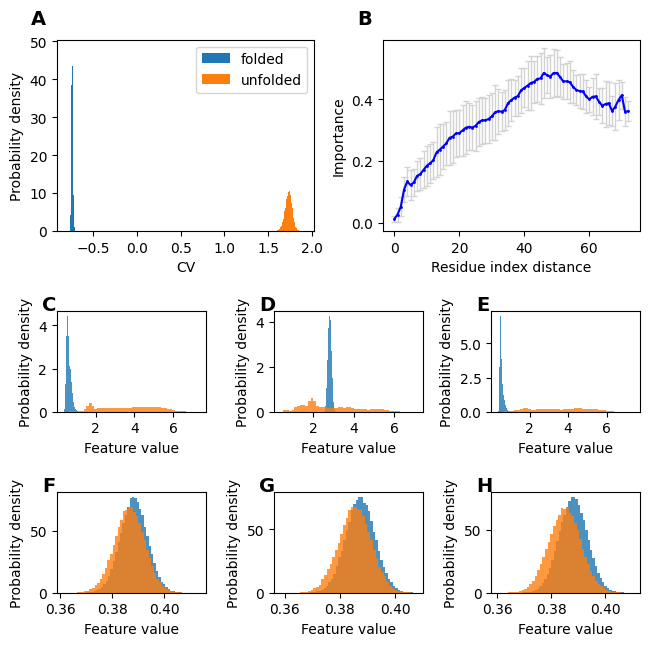

In [52]:
# Plotting
import matplotlib.gridspec as gridspec
import string
fig = plt.figure(figsize=(6.6, 6.6))  # adjust size as needed
gs = gridspec.GridSpec(7, 6, figure=fig)  # 6 columns total for flexibility
ax1 = fig.add_subplot(gs[0:3, 0:3])
ax2 = fig.add_subplot(gs[0:3, 3:6])
ax3 = fig.add_subplot(gs[3:5, 0:2])
ax4 = fig.add_subplot(gs[3:5, 2:4])
ax5 = fig.add_subplot(gs[3:5, 4:6])
ax6 = fig.add_subplot(gs[5:7, 0:2])
ax7 = fig.add_subplot(gs[5:7, 2:4])
ax8 = fig.add_subplot(gs[5:7, 4:6])
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]
# Histogram of distribution of CV
ax1.hist(folded_cv, bins=50, density=True, label="folded")
ax1.hist(unfolded_cv, bins=50, density=True, label="unfolded")
ax1.set_xlabel("CV")
ax1.set_ylabel("Probability density")
ax1.legend()
# Residue index dist vs importance
avg_weight_per_distance = {}
for distance, weight in zip(i_j_dist, importance):
    if distance not in avg_weight_per_distance:
        avg_weight_per_distance[distance] = []
    avg_weight_per_distance[distance].append(weight)
for distance in sorted(avg_weight_per_distance.keys()):
    avg_score = np.mean(avg_weight_per_distance[distance])
    #print(f"|i - j| = {distance}: Average Importance Score = {avg_score:.9f}")
avg_distances = sorted(avg_weight_per_distance.keys())
avg_importance = [np.mean(avg_weight_per_distance[distance]) for distance in avg_distances]
std_importance = [np.std(avg_weight_per_distance[distance]) for distance in avg_distances]
ax2.errorbar(avg_distances, avg_importance, yerr=std_importance, fmt='o-', color='b', ecolor='lightgray', elinewidth=1, capsize=2, markersize=1)
ax2.set_xlabel("Residue index distance")
ax2.set_ylabel("Importance")

# Top 3 important
for i in range(3):
    col_ndx = top_features_indices[i]
    feature_folded = X_np[:120001,col_ndx]
    feature_unfolded = X_np[120001:,col_ndx]
    axes[i+2].hist(feature_folded, bins=50, density=True, alpha=0.8)
    axes[i+2].hist(feature_unfolded, bins=50, density=True, alpha=0.8)
    axes[i+2].set_xticks([2, 4, 6])
    axes[i+2].set_xlabel("Feature value")
    axes[i+2].set_ylabel("Probability density")
# Bottom 3 important
for i in range(3):
    col_ndx = bot_features_indices[i]
    feature_folded = X_np[:120001,col_ndx]
    feature_unfolded = X_np[120001:,col_ndx]
    axes[i+5].hist(feature_folded, bins=50, density=True, alpha=0.8)
    axes[i+5].hist(feature_unfolded, bins=50, density=True, alpha=0.8)
    axes[i+5].set_xlabel("Feature value")
    axes[i+5].set_ylabel("Probability density")

for ax_panel, panel_label in zip(axes, string.ascii_uppercase):
    ax_panel.text(
        -0.1, 1.16,
        panel_label,
        transform=ax_panel.transAxes,
        fontsize=14,
        fontweight='bold',
        va='top',
        ha='left',
    )
    ax_panel.set_facecolor((0, 0, 0, 0))
fig.patch.set_alpha(0)            # Figure background
fig.tight_layout()

## HLDA, Carlo's, Lasso

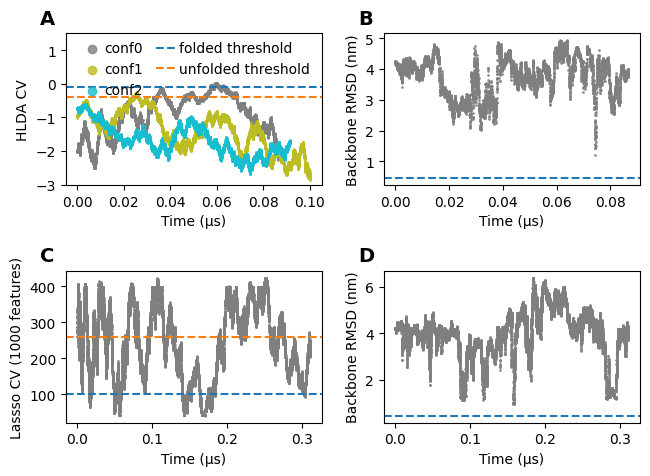

In [164]:
import string
# Initialise the plot
fig, ax = plt.subplots(2, 2, figsize=(6.6, 4.9))

########
# HLDA #
########
files_b = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/hlda/conf1/COLVAR",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/hlda/conf0/COLVAR",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/hlda/conf2_nopbc/COLVAR"]
labels_b = ["conf0", "conf1", "conf2"]
#colors_b = ["#2f2f2f","#888c86","#dcd6ba"]
colors_b = ["C7","C8","C9"]

for file, label, color in zip(files_b, labels_b, colors_b):
    time, cv = load_colvar(file, "comb", start=0, )#stop=50000)
    time = time / 1000000   # Convert ps to µs
    ax[0,0].scatter(time, cv, alpha=0.8, label=label, s=1, color=color)

ax[0,0].axhline(-0.085469, color='C0', linestyle='--', label='folded threshold')
ax[0,0].axhline(-0.392726, color='C1', linestyle='--', label='unfolded threshold')
ax[0,0].set_ylim(top=1.5)
ax[0,0].set_xlabel("Time (µs)")
ax[0,0].set_ylabel("HLDA CV")
ax[0,0].legend(loc="upper right", 
               bbox_to_anchor=(1.0, 1.03),  # (x, y): move y from 1.0 to 1.035
               frameon=False, 
               ncol=2, 
               handletextpad=0.1,  # reduce space between marker and text
               columnspacing=1.0,
               handlelength=1.5,
               markerscale=6
               )

files_rmsd = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/hlda/conf1/rmsd_from_native.xvg"]
for file, label in zip(files_rmsd, labels_b):
    time, rmsd = np.genfromtxt(file, skip_header=18, unpack=True)
    time = time / 1000000   # Convert ps to µs
    ax[0,1].scatter(time, rmsd, alpha=0.8, label=label, s=1, color="C7")
ax[0,1].axhline(0.4532633, color='C0', linestyle='--', label='Folded threshold')
ax[0,1].set_xlabel("Time (µs)")
ax[0,1].set_ylabel("Backbone RMSD (nm)")
#ax[0,1].set_ylim(top=6)

##################
# Lasso top 1000 #
##################
files_b = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/lasso_top1000/conf0/COLVAR"]
labels_b = ["conf0", "conf1", "conf2"]
#colors_b = ["#2f2f2f","#888c86","#dcd6ba"]
colors_b = ["C7","C8","C9"]

for file, label, color in zip(files_b, labels_b, colors_b):
    time, cv = load_colvar(file, "lassoCV", start=0, )#stop=50000)
    time = time / 1000000   # Convert ps to µs
    ax[1,0].scatter(time, cv, alpha=0.8, label=label, s=1, color=color)

ax[1,0].axhline(100.599947, color='C0', linestyle='--', label='folded threshold')
ax[1,0].axhline(260.071831, color='C1', linestyle='--', label='unfolded threshold')
#ax[1,0].set_ylim(top=1.5)
ax[1,0].set_xlabel("Time (µs)")
ax[1,0].set_ylabel("Lassso CV (1000 features)")

files_rmsd = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/lasso_top1000/conf0/rmsd_from_native.xvg"]
for file, label in zip(files_rmsd, labels_b):
    time, rmsd = np.genfromtxt(file, skip_header=18, unpack=True)
    time = time / 1000000   # Convert ps to µs
    ax[1,1].scatter(time, rmsd, alpha=0.8, label=label, s=1, color="C7")
ax[1,1].axhline(0.4532633, color='C0', linestyle='--', label='Folded threshold')
ax[1,1].set_xlabel("Time (µs)")
ax[1,1].set_ylabel("Backbone RMSD (nm)")

for ax_panel, panel_label in zip(ax.flatten(), string.ascii_uppercase):
    ax_panel.text(
        -0.1, 1.16,
        panel_label,
        transform=ax_panel.transAxes,
        fontsize=14,
        fontweight='bold',
        va='top',
        ha='left',
    )
    ax_panel.set_facecolor((0, 0, 0, 0))
fig.patch.set_alpha(0)            # Figure background
fig.tight_layout()

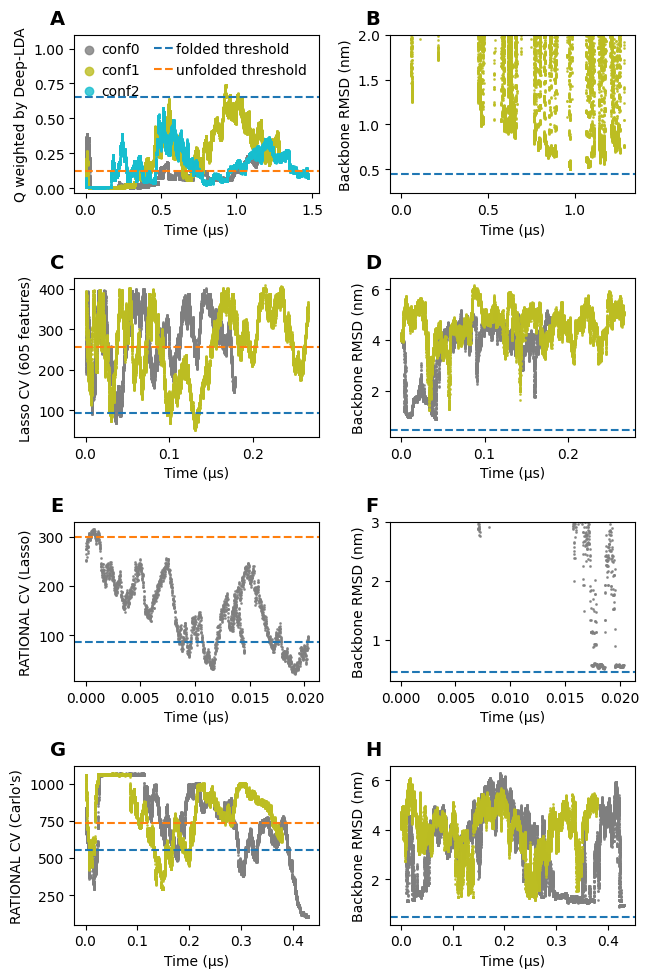

In [165]:
# Improving the contact map CVs
# Initialise the plot
fig, ax = plt.subplots(4, 2, figsize=(6.6, 9.9))

#######################
# Deep-LDA importance #
#######################
files_b = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_Q_reweighted_importance/conf0/COLVAR",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_Q_reweighted_importance/conf1/COLVAR",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_Q_reweighted_importance/conf2/COLVAR"]
labels_b = ["conf0", "conf1", "conf2"]
#colors_b = ["#2f2f2f","#888c86","#dcd6ba"]
colors_b = ["C7","C8","C9"]

for file, label, color in zip(files_b, labels_b, colors_b):
    time, cv = load_colvar(file, "native", start=0, )#stop=50000)
    time = time / 1000000   # Convert ps to µs
    ax[0,0].scatter(time, cv, alpha=0.8, label=label, s=1, color=color)

ax[0,0].axhline(0.649798, color='C0', linestyle='--', label='folded threshold')
ax[0,0].axhline(0.122975, color='C1', linestyle='--', label='unfolded threshold')
ax[0,0].set_ylim(top=1.1)
ax[0,0].set_xlabel("Time (µs)")
ax[0,0].set_ylabel("Q weighted by Deep-LDA")
ax[0,0].legend(loc="upper right", 
               bbox_to_anchor=(1.0, 1.03),  # (x, y): move y from 1.0 to 1.035
               frameon=False, 
               ncol=2, 
               handletextpad=0.1,  # reduce space between marker and text
               columnspacing=1.0,
               handlelength=1.5,
               markerscale=6
               )

files_rmsd = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_Q_reweighted_importance/conf1/rmsd_from_native.xvg"]
for file, label in zip(files_rmsd, labels_b):
    time, rmsd = np.genfromtxt(file, skip_header=18, unpack=True)
    time = time / 1000000   # Convert ps to µs
    ax[0,1].scatter(time, rmsd, alpha=0.8, label=label, s=1, color="C8")
ax[0,1].axhline(0.4532633, color='C0', linestyle='--', label='Folded threshold')
ax[0,1].set_xlabel("Time (µs)")
ax[0,1].set_ylabel("Backbone RMSD (nm)")
ax[0,1].set_ylim(top=2)

################
# Lasso native #
################
files_b = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/lasso_native_dist/conf0/COLVAR",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/lasso_native_dist/conf1/COLVAR"]
labels_b = ["conf0", "conf1"]
#colors_b = ["#2f2f2f","#888c86","#dcd6ba"]
colors_b = ["C7","C8","C9"]

for file, label, color in zip(files_b, labels_b, colors_b):
    time, cv = load_colvar(file, "lassoCV", start=0, )#stop=50000)
    time = time / 1000000   # Convert ps to µs
    ax[1,0].scatter(time, cv, alpha=0.8, label=label, s=1, color=color)

ax[1,0].axhline(93.670028, color='C0', linestyle='--', label='folded threshold')
ax[1,0].axhline(255.267269, color='C1', linestyle='--', label='unfolded threshold')
#ax[2,0].set_ylim(top=1.5)
ax[1,0].set_xlabel("Time (µs)")
ax[1,0].set_ylabel("Lasso CV (605 features)")

files_rmsd = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/lasso_native_dist/conf0/rmsd_from_native.xvg",
              "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/lasso_native_dist/conf1/rmsd_from_native.xvg"]
for file, label, color in zip(files_rmsd, labels_b, colors_b):
    time, rmsd = np.genfromtxt(file, skip_header=18, unpack=True)
    time = time / 1000000   # Convert ps to µs
    ax[1,1].scatter(time, rmsd, alpha=0.8, label=label, s=1, color=color)
ax[1,1].axhline(0.4532633, color='C0', linestyle='--', label='Folded threshold')
ax[1,1].set_xlabel("Time (µs)")
ax[1,1].set_ylabel("Backbone RMSD (nm)")

#########################
# Lasso native RATIONAL #
#########################
files_b = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational_lasso_TDA/conf0/COLVAR"]
labels_b = ["conf0", "conf1"]
#colors_b = ["#2f2f2f","#888c86","#dcd6ba"]
colors_b = ["C7","C8","C9"]

for file, label, color in zip(files_b, labels_b, colors_b):
    time, cv = load_colvar(file, "native", start=0, stop=2200)
    time = time / 1000000   # Convert ps to µs
    ax[2,0].scatter(time, cv, alpha=0.8, label=label, s=1, color=color)

ax[2,0].axhline(86.573164, color='C0', linestyle='--', label='folded threshold')
ax[2,0].axhline(299.183465, color='C1', linestyle='--', label='unfolded threshold')
#ax[2,0].set_ylim(top=1.5)
ax[2,0].set_xlabel("Time (µs)")
ax[2,0].set_ylabel("RATIONAL CV (Lasso)")

files_rmsd = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational_lasso_TDA/conf0/rmsd_from_native.xvg"]
for file, label in zip(files_rmsd, labels_b):
    time, rmsd = np.genfromtxt(file, skip_header=18, unpack=True)
    time = time / 1000000   # Convert ps to µs
    ax[2,1].scatter(time, rmsd, alpha=0.8, label=label, s=1, color="C7")
ax[2,1].axhline(0.4532633, color='C0', linestyle='--', label='Folded threshold')
ax[2,1].set_xlabel("Time (µs)")
ax[2,1].set_ylabel("Backbone RMSD (nm)")
ax[2,1].set_ylim(top=3)

###########
# Carlo's #
###########
files_b = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational_reweighted_2021/conf0/COLVAR",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational_reweighted_2021/conf1/COLVAR"]
labels_b = ["conf0", "conf1"]
#colors_b = ["#2f2f2f","#888c86","#dcd6ba"]
colors_b = ["C7","C8","C9"]

for file, label, color in zip(files_b, labels_b, colors_b):
    time, cv = load_colvar(file, "native", start=0)
    time = time / 1000000   # Convert ps to µs
    ax[3,0].scatter(time, cv, alpha=0.8, label=label, s=1, color=color)

ax[3,0].axhline(553.833655, color='C0', linestyle='--', label='folded threshold')
ax[3,0].axhline(736.956850, color='C1', linestyle='--', label='unfolded threshold')
#ax[2,0].set_ylim(top=1.5)
ax[3,0].set_xlabel("Time (µs)")
ax[3,0].set_ylabel("RATIONAL CV (Carlo's)")

files_rmsd = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational_reweighted_2021/conf0/rmsd_from_native.xvg", 
              "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational_reweighted_2021/conf1/rmsd_from_native.xvg"]
for file, label, color in zip(files_rmsd, labels_b, colors_b):
    time, rmsd = np.genfromtxt(file, skip_header=18, unpack=True)
    time = time / 1000000   # Convert ps to µs
    ax[3,1].scatter(time, rmsd, alpha=0.8, label=label, s=1, color=color)
ax[3,1].axhline(0.4532633, color='C0', linestyle='--', label='Folded threshold')
ax[3,1].set_xlabel("Time (µs)")
ax[3,1].set_ylabel("Backbone RMSD (nm)")

for ax_panel, panel_label in zip(ax.flatten(), string.ascii_uppercase):
    ax_panel.text(
        -0.1, 1.16,
        panel_label,
        transform=ax_panel.transAxes,
        fontsize=14,
        fontweight='bold',
        va='top',
        ha='left',
    )
    ax_panel.set_facecolor((0, 0, 0, 0))
fig.patch.set_alpha(0)            # Figure background
fig.tight_layout()

# Other unsucessful attempts to improve the contact map CV

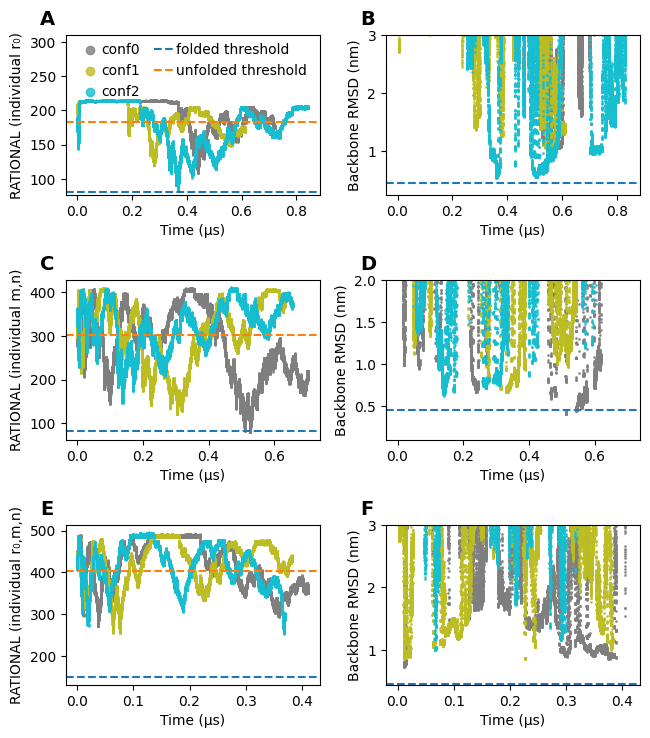

In [81]:
# Improving the contact map CVs
# Initialise the plot
fig, ax = plt.subplots(3, 2, figsize=(6.6, 7.5))

################
# Specific R_0 #
################
files_b = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational_R_0/conf0/COLVAR",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational_R_0/conf1/COLVAR",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational_R_0/conf2/COLVAR"]
labels_b = ["conf0", "conf1", "conf2"]
#colors_b = ["#2f2f2f","#888c86","#dcd6ba"]
colors_b = ["C7","C8","C9"]

for file, label, color in zip(files_b, labels_b, colors_b):
    time, cv = load_colvar(file, "native", start=0, )#stop=50000)
    time = time / 1000000   # Convert ps to µs
    ax[0,0].scatter(time, cv, alpha=0.8, label=label, s=1, color=color)

ax[0,0].axhline(80.697472, color='C0', linestyle='--', label='folded threshold')
ax[0,0].axhline(183.589366, color='C1', linestyle='--', label='unfolded threshold')
ax[0,0].set_ylim(top=310)
ax[0,0].set_xlabel("Time (µs)")
ax[0,0].set_ylabel("RATIONAL (individual r₀)")
ax[0,0].legend(loc="upper right", 
               bbox_to_anchor=(1.0, 1.03),  # (x, y): move y from 1.0 to 1.035
               frameon=False, 
               ncol=2, 
               handletextpad=0.1,  # reduce space between marker and text
               columnspacing=1.0,
               handlelength=1.5,
               markerscale=6
               )

files_rmsd = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational_R_0/conf0/rmsd_from_native.xvg",
              "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational_R_0/conf1/rmsd_from_native.xvg",
              "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational_R_0/conf2/rmsd_from_native.xvg"]
for file, label, color in zip(files_rmsd, labels_b, colors_b):
    time, rmsd = np.genfromtxt(file, skip_header=18, unpack=True)
    time = time / 1000000   # Convert ps to µs
    ax[0,1].scatter(time, rmsd, alpha=0.8, label=label, s=1, color=color)
ax[0,1].axhline(0.4532633, color='C0', linestyle='--', label='Folded threshold')
ax[0,1].set_xlabel("Time (µs)")
ax[0,1].set_ylabel("Backbone RMSD (nm)")
ax[0,1].set_ylim(top=3)

################
# Specific m,n #
################
files_b = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational_mn/conf0/COLVAR",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational_mn/conf1/COLVAR",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational_mn/conf2/COLVAR"]
labels_b = ["conf0", "conf1", "conf2"]
#colors_b = ["#2f2f2f","#888c86","#dcd6ba"]
colors_b = ["C7","C8","C9"]

for file, label, color in zip(files_b, labels_b, colors_b):
    time, cv = load_colvar(file, "native", start=0, )#stop=50000)
    time = time / 1000000   # Convert ps to µs
    ax[1,0].scatter(time, cv, alpha=0.8, label=label, s=1, color=color)

ax[1,0].axhline(81.742001, color='C0', linestyle='--', label='folded threshold')
ax[1,0].axhline(300.989418, color='C1', linestyle='--', label='unfolded threshold')
#ax[2,0].set_ylim(top=1.5)
ax[1,0].set_xlabel("Time (µs)")
ax[1,0].set_ylabel("RATIONAL (individual m,n)")

files_rmsd = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational_mn/conf0/rmsd_from_native.xvg",
              "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational_mn/conf1/rmsd_from_native.xvg",
              "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational_mn/conf2/rmsd_from_native.xvg"]
for file, label, color in zip(files_rmsd, labels_b, colors_b):
    time, rmsd = np.genfromtxt(file, skip_header=18, unpack=True)
    time = time / 1000000   # Convert ps to µs
    ax[1,1].scatter(time, rmsd, alpha=0.8, label=label, s=1, color=color)
ax[1,1].axhline(0.4532633, color='C0', linestyle='--', label='Folded threshold')
ax[1,1].set_xlabel("Time (µs)")
ax[1,1].set_ylabel("Backbone RMSD (nm)")
ax[1,1].set_ylim(top=2)

######################
# Specific R_0 + m,n #
######################
files_b = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational_r0_nm/conf0/COLVAR",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational_r0_nm/conf1/COLVAR",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational_r0_nm/conf2/COLVAR"]
labels_b = ["conf0", "conf1", "conf2"]
#colors_b = ["#2f2f2f","#888c86","#dcd6ba"]
colors_b = ["C7","C8","C9"]

for file, label, color in zip(files_b, labels_b, colors_b):
    time, cv = load_colvar(file, "native", start=0)
    time = time / 1000000   # Convert ps to µs
    ax[2,0].scatter(time, cv, alpha=0.8, label=label, s=1, color=color)

ax[2,0].axhline(148.334654, color='C0', linestyle='--', label='folded threshold')
ax[2,0].axhline(402.900379, color='C1', linestyle='--', label='unfolded threshold')
#ax[2,0].set_ylim(top=1.5)
ax[2,0].set_xlabel("Time (µs)")
ax[2,0].set_ylabel("RATIONAL (individual r₀,m,n)")

files_rmsd = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational_r0_nm/conf0/rmsd_from_native.xvg",
              "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational_r0_nm/conf1/rmsd_from_native.xvg",
              "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational_r0_nm/conf2/rmsd_from_native.xvg"]
for file, label, color in zip(files_rmsd, labels_b, colors_b):
    time, rmsd = np.genfromtxt(file, skip_header=18, unpack=True)
    time = time / 1000000   # Convert ps to µs
    ax[2,1].scatter(time, rmsd, alpha=0.8, label=label, s=1, color=color)
ax[2,1].axhline(0.4532633, color='C0', linestyle='--', label='Folded threshold')
ax[2,1].set_xlabel("Time (µs)")
ax[2,1].set_ylabel("Backbone RMSD (nm)")
ax[2,1].set_ylim(top=3)

for ax_panel, panel_label in zip(ax.flatten(), string.ascii_uppercase):
    ax_panel.text(
        -0.1, 1.16,
        panel_label,
        transform=ax_panel.transAxes,
        fontsize=14,
        fontweight='bold',
        va='top',
        ha='left',
    )
    ax_panel.set_facecolor((0, 0, 0, 0))
fig.patch.set_alpha(0)            # Figure background
fig.tight_layout()

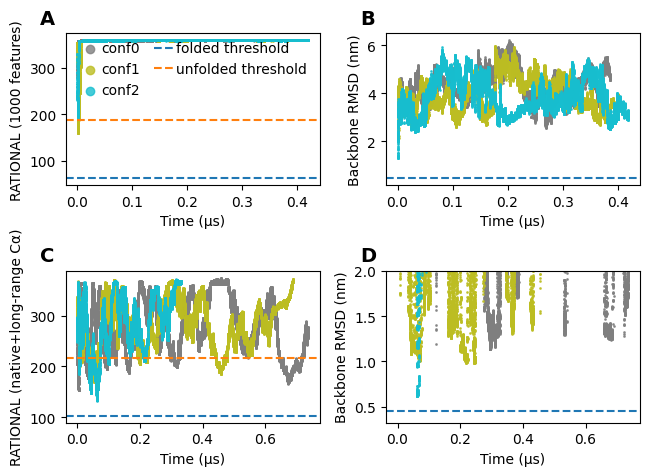

In [91]:
# Improving the contact map CVs
# Initialise the plot
fig, ax = plt.subplots(2, 2, figsize=(6.6, 4.9))

############################
# Specific R_0, 1000 ca+sc #
############################
files_b = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/ca_sc_rational/conf0/COLVAR",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/ca_sc_rational/conf1/COLVAR",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/ca_sc_rational/conf2/COLVAR"]
labels_b = ["conf0", "conf1", "conf2"]
#colors_b = ["#2f2f2f","#888c86","#dcd6ba"]
colors_b = ["C7","C8","C9"]

for file, label, color in zip(files_b, labels_b, colors_b):
    time, cv = load_colvar(file, "ca_sc_1000", start=0, )#stop=50000)
    time = time / 1000000   # Convert ps to µs
    ax[0,0].scatter(time, cv, alpha=0.8, label=label, s=1, color=color)

ax[0,0].axhline(61.586262, color='C0', linestyle='--', label='folded threshold')
ax[0,0].axhline(187.448595, color='C1', linestyle='--', label='unfolded threshold')
#ax[0,0].set_ylim(top=310)
ax[0,0].set_xlabel("Time (µs)")
ax[0,0].set_ylabel("RATIONAL (1000 features)")
ax[0,0].legend(loc="upper right", 
               bbox_to_anchor=(1.0, 1.03),  # (x, y): move y from 1.0 to 1.035
               frameon=False, 
               ncol=2, 
               handletextpad=0.1,  # reduce space between marker and text
               columnspacing=1.0,
               handlelength=1.5,
               markerscale=6
               )

files_rmsd = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/ca_sc_rational/conf0/rmsd_from_native.xvg",
              "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/ca_sc_rational/conf1/rmsd_from_native.xvg",
              "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/ca_sc_rational/conf2/rmsd_from_native.xvg"]
for file, label, color in zip(files_rmsd, labels_b, colors_b):
    time, rmsd = np.genfromtxt(file, skip_header=18, unpack=True)
    time = time / 1000000   # Convert ps to µs
    ax[0,1].scatter(time, rmsd, alpha=0.8, label=label, s=1, color=color)
ax[0,1].axhline(0.4532633, color='C0', linestyle='--', label='Folded threshold')
ax[0,1].set_xlabel("Time (µs)")
ax[0,1].set_ylabel("Backbone RMSD (nm)")
#ax[0,1].set_ylim(top=3)

#################################
# RATIONAL native+long-range ca #
#################################
files_b = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_lrca_rational_R_0/conf0/COLVAR",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_lrca_rational_R_0/conf1/COLVAR",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_lrca_rational_R_0/conf2/COLVAR"]
labels_b = ["conf0", "conf1", "conf2"]
#colors_b = ["#2f2f2f","#888c86","#dcd6ba"]
colors_b = ["C7","C8","C9"]

for file, label, color in zip(files_b, labels_b, colors_b):
    time, cv = load_colvar(file, "native", start=0, )#stop=50000)
    time = time / 1000000   # Convert ps to µs
    ax[1,0].scatter(time, cv, alpha=0.8, label=label, s=1, color=color)

ax[1,0].axhline(102.657002, color='C0', linestyle='--', label='folded threshold')
ax[1,0].axhline(216.700308, color='C1', linestyle='--', label='unfolded threshold')
#ax[2,0].set_ylim(top=1.5)
ax[1,0].set_xlabel("Time (µs)")
ax[1,0].set_ylabel("RATIONAL (native+long-range Cα)")

files_rmsd = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_lrca_rational_R_0/conf0/rmsd_from_native.xvg",
              "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_lrca_rational_R_0/conf1/rmsd_from_native.xvg",
              "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_lrca_rational_R_0/conf2/rmsd_from_native.xvg"]
for file, label, color in zip(files_rmsd, labels_b, colors_b):
    time, rmsd = np.genfromtxt(file, skip_header=18, unpack=True)
    time = time / 1000000   # Convert ps to µs
    ax[1,1].scatter(time, rmsd, alpha=0.8, label=label, s=1, color=color)
ax[1,1].axhline(0.4532633, color='C0', linestyle='--', label='Folded threshold')
ax[1,1].set_xlabel("Time (µs)")
ax[1,1].set_ylabel("Backbone RMSD (nm)")
ax[1,1].set_ylim(top=2)

for ax_panel, panel_label in zip(ax.flatten(), string.ascii_uppercase):
    ax_panel.text(
        -0.1, 1.16,
        panel_label,
        transform=ax_panel.transAxes,
        fontsize=14,
        fontweight='bold',
        va='top',
        ha='left',
    )
    ax_panel.set_facecolor((0, 0, 0, 0))
fig.patch.set_alpha(0)            # Figure background
fig.tight_layout()

# Balancing Exploration and Convergence

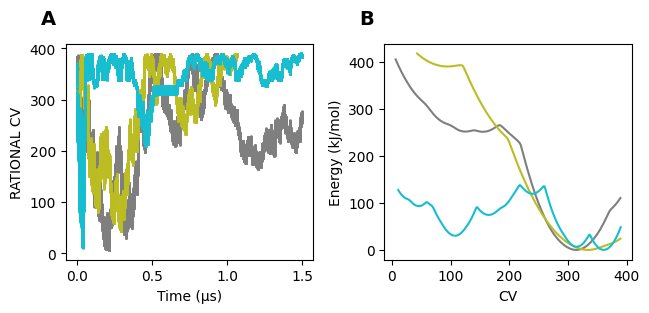

In [32]:
#####################
# OPES+OPES explore #
#####################
fig, ax = plt.subplots(1, 2, figsize=(6.6, 3.3))

files = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational_opes_and_opes_explore/production/conf0/COLVAR",
         "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational_opes_and_opes_explore/production/conf1/COLVAR",
         "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational_opes_and_opes_explore/production/conf2/COLVAR"]
labels = ["conf0", "conf1", "conf2"]
colors = ["C7","C8","C9"]

for file, label, color in zip(files, labels, colors):
    time, cv = load_colvar(file, "native", start=0, stop=150000)
    time = time / 1000000   # Convert ps to µs
    ax[0].scatter(time, cv, alpha=0.8, label=label, s=1, color=color)
ax[0].set_xlabel("Time (µs)")
ax[0].set_ylabel("RATIONAL CV")

files = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational_opes_and_opes_explore/production/conf0/FES_1D",
         "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational_opes_and_opes_explore/production/conf1/FES_1D",
         "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational_opes_and_opes_explore/production/conf2/FES_1D"]
for file, label, color in zip(files, labels, colors):
    cv, fe = np.genfromtxt(file,skip_header=7, unpack=True)
    ax[1].plot(cv, fe, color=color)
ax[1].set_xlabel("CV")
ax[1].set_ylabel("Energy (kJ/mol)")

for ax_panel, panel_label in zip(ax, string.ascii_uppercase):
    ax_panel.text(
        -0.1, 1.16,
        panel_label,
        transform=ax_panel.transAxes,
        fontsize=14,
        fontweight='bold',
        va='top',
        ha='left',
    )
    ax_panel.set_facecolor((0, 0, 0, 0))
fig.patch.set_alpha(0)            # Figure background
fig.tight_layout()

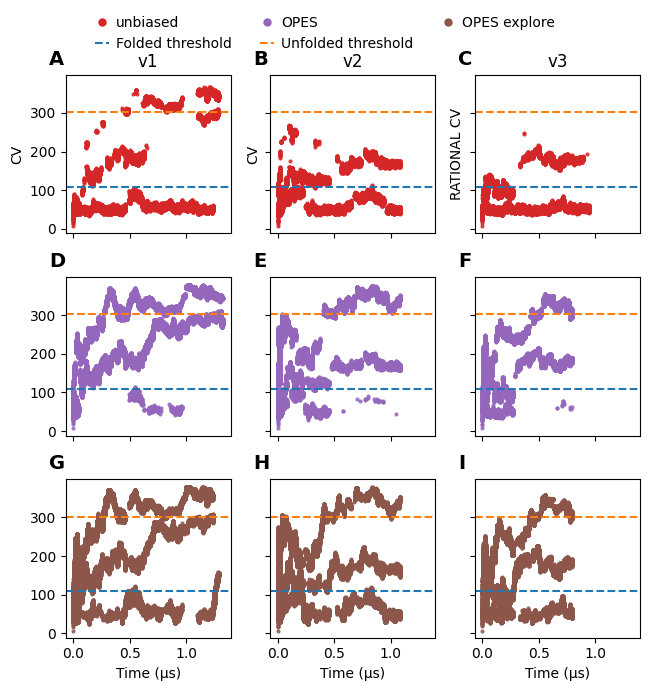

In [162]:
######################
# OPES bias exchange #
######################
fig, ax = plt.subplots(3, 3, figsize=(6.6, 6.6), sharex=True, sharey=True)
############################
# Bias exchange velocity 1 #
############################
files_a = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/folded/COLVARS/COLVAR_native_rational",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/unfolded/COLVARS/COLVAR_native_rational"]
labels_a = ["unfolded", "folded"]
files_b = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/bremd/unfolding/conf0_1/COLVAR_native_rational",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/bremd/unfolding/conf0_1/COLVAR_native_rational.1",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/bremd/unfolding/conf0_1/COLVAR_native_rational.2"]
files_b = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/bremd/unfolding/conf0_1/COLVAR.0",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/bremd/unfolding/conf0_1/COLVAR.1",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/bremd/unfolding/conf0_1/COLVAR.2"]
labels_b = ["unbiased", 'OPES', "OPES explore"]
colours_b = ["C3","C4","C5"]
i = 0
for file, label in zip(files_b, labels_b):
    time, cv = load_colvar(file, "native", start=0, )#stop=50000)
    time = time / 1000000   # Convert ps to us
    ax[i,0].plot(time, cv, linestyle="none", marker="o", markersize=2, alpha=0.8, color=colours_b[i], label=label)
    ax[i,0].axhline(109.533825, color='C0', linestyle='--', label='Folded threshold')
    ax[i,0].axhline(301.900249, color='C1', linestyle='--', label='Unfolded threshold')
    i += 1
ax[0,0].set_title("v1")
ax[2,0].set_xlabel("Time (µs)")
ax[0,0].set_ylabel("CV")

############################
# Bias exchange velocity 2 #
############################
files_a = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/folded/COLVARS/COLVAR_native_rational",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/unfolded/COLVARS/COLVAR_native_rational"]
labels_a = ["unfolded", "folded"]
files_b = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/bremd/unfolding/conf0_1/COLVAR_native_rational",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/bremd/unfolding/conf0_1/COLVAR_native_rational.1",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/bremd/unfolding/conf0_1/COLVAR_native_rational.2"]
files_b = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/bremd/unfolding/conf0_2/COLVAR.0",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/bremd/unfolding/conf0_2/COLVAR.1",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/bremd/unfolding/conf0_2/COLVAR.2"]
labels_b = ["unbiased", 'OPES', "OPES explore"]
colours_b = ["C3","C4","C5"]
i = 0
for file, label in zip(files_b, labels_b):
    time, cv = load_colvar(file, "native", start=0, )#stop=50000)
    time = time / 1000000   # Convert ps to us
    ax[i,1].plot(time, cv, linestyle="none", marker="o", markersize=2, alpha=0.8, color=colours_b[i], label=label)
    ax[i,1].axhline(109.533825, color='C0', linestyle='--', label='Folded threshold')
    ax[i,1].axhline(301.900249, color='C1', linestyle='--', label='Unfolded threshold')
    i += 1
ax[0,1].set_title("v2")
ax[2,1].set_xlabel("Time (µs)")
ax[0,1].set_ylabel("CV")

############################
# Bias exchange velocity 3 #
############################
files_a = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/folded/COLVARS/COLVAR_native_rational",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/unfolded/COLVARS/COLVAR_native_rational"]
labels_a = ["unfolded", "folded"]
files_b = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/bremd/unfolding/conf0_1/COLVAR_native_rational",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/bremd/unfolding/conf0_1/COLVAR_native_rational.1",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/bremd/unfolding/conf0_1/COLVAR_native_rational.2"]
files_b = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/bremd/unfolding/conf0_3/COLVAR.0",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/bremd/unfolding/conf0_3/COLVAR.1",
           "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/bremd/unfolding/conf0_3/COLVAR.2"]
labels_b = ["unbiased", 'OPES', "OPES explore"]
colours_b = ["C3","C4","C5"]
i = 0
for file, label in zip(files_b, labels_b):
    time, cv = load_colvar(file, "native", start=0, )#stop=50000)
    time = time / 1000000   # Convert ps to us
    ax[i,2].plot(time, cv, linestyle="none", marker="o", markersize=2, alpha=0.8, color=colours_b[i], label=label)
    ax[i,2].axhline(109.533825, color='C0', linestyle='--', label='Folded threshold')
    ax[i,2].axhline(301.900249, color='C1', linestyle='--', label='Unfolded threshold')
    i += 1
ax[0,2].set_title("v3")
ax[2,2].set_xlabel("Time (µs)")
ax[0,2].set_ylabel("RATIONAL CV")

legend_elements = [
    Line2D([0], [0], marker='o', color='none', label='unbiased', markerfacecolor='C3', markersize=6, markeredgewidth=0),
    Line2D([0], [0], color='C0', linestyle='--', label='Folded threshold'),
    Line2D([0], [0], marker='o', color='none', label='OPES', markerfacecolor='C4', markersize=6, markeredgewidth=0),
    Line2D([0], [0], color='C1', linestyle='--', label='Unfolded threshold'),
    Line2D([0], [0], marker='o', color='none', label='OPES explore', markerfacecolor='C5', markersize=6, markeredgewidth=0),
]
fig.legend(
    handles=legend_elements,
    loc='upper center',
    ncol=3,
    bbox_to_anchor=(0.5, 1.05),
    handletextpad=0.5,  # reduce space between marker and text
    frameon=False, 
    handlelength=1
)

for ax_panel, panel_label in zip(ax.flatten(), string.ascii_uppercase):
    ax_panel.text(
        -0.1, 1.16,
        panel_label,
        transform=ax_panel.transAxes,
        fontsize=14,
        fontweight='bold',
        va='top',
        ha='left',
    )
    ax_panel.set_facecolor((0, 0, 0, 0))
fig.patch.set_alpha(0)            # Figure background
fig.tight_layout()

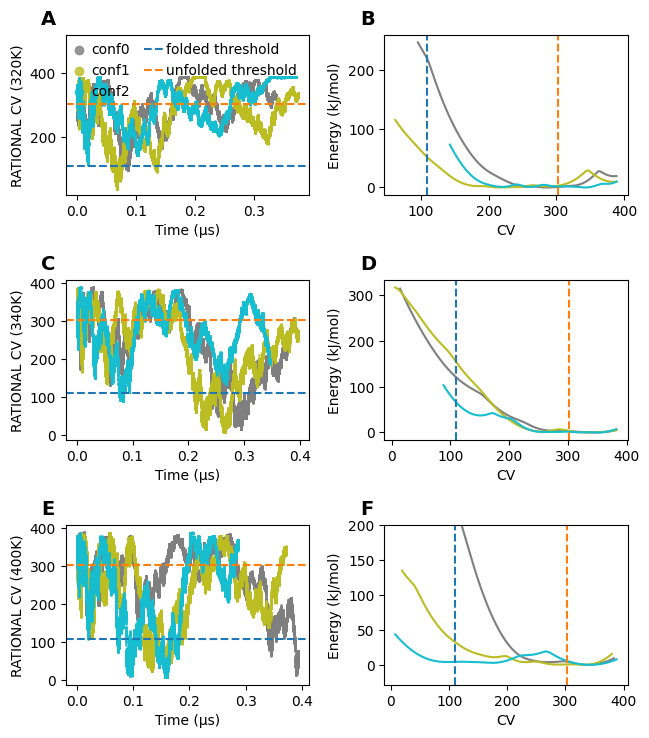

In [160]:
# multithermal
fig, ax = plt.subplots(3, 2, figsize=(6.6, 7.5))

########
# 320K #
########
files = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational/320K/conf0/COLVAR",
         "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational/320K/conf1/COLVAR",
         "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational/320K/conf2/COLVAR"]
labels = ["conf0", "conf1", "conf2"]
colors = ["C7","C8","C9"]

for file, label, color in zip(files, labels, colors):
    time, cv = load_colvar(file, "native", start=0, )#stop=50000)
    time = time / 1000000   # Convert ps to µs
    ax[0,0].scatter(time, cv, alpha=0.8, label=label, s=1, color=color)

ax[0,0].axhline(109.533825, color='C0', linestyle='--', label='folded threshold')
ax[0,0].axhline(301.900249, color='C1', linestyle='--', label='unfolded threshold')
ax[0,0].set_ylim(top=520)
ax[0,0].set_xlabel("Time (µs)")
ax[0,0].set_ylabel("RATIONAL CV (320K)")
ax[0,0].legend(loc="upper right", 
               bbox_to_anchor=(1.0, 1.03),  # (x, y): move y from 1.0 to 1.035
               frameon=False, 
               ncol=2, 
               handletextpad=0.1,  # reduce space between marker and text
               columnspacing=1.0,
               handlelength=1.5,
               markerscale=6
               )
# FES
files = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational/320K/conf0/FES_1D",
         "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational/320K/conf1/FES_1D",
         "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational/320K/conf2/FES_1D"]
for file, label, color in zip(files, labels, colors):
    cv, fe = np.genfromtxt(file,skip_header=7, unpack=True)
    ax[0,1].plot(cv, fe, color=color)
ax[0,1].axvline(109.533825, color='C0', linestyle='--', label='Folded threshold')
ax[0,1].axvline(301.900249, color='C1', linestyle='--', label='Unfolded threshold')
ax[0,1].set_xlabel("CV")
ax[0,1].set_ylabel("Energy (kJ/mol)")

########
# 340K #
########
files = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational/340K/conf0/COLVAR",
         "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational/340K/conf1/COLVAR",
         "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational/340K/conf2/COLVAR"]
labels = ["conf0", "conf1", "conf2"]
colors = ["C7","C8","C9"]

for file, label, color in zip(files, labels, colors):
    time, cv = load_colvar(file, "native", start=0, )#stop=50000)
    time = time / 1000000   # Convert ps to µs
    ax[1,0].scatter(time, cv, alpha=0.8, label=label, s=1, color=color)

ax[1,0].axhline(109.533825, color='C0', linestyle='--', label='folded threshold')
ax[1,0].axhline(301.900249, color='C1', linestyle='--', label='unfolded threshold')
ax[1,0].set_xlabel("Time (µs)")
ax[1,0].set_ylabel("RATIONAL CV (340K)")
# FES
files = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational/340K/conf0/FES_1D",
         "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational/340K/conf1/FES_1D",
         "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational/340K/conf2/FES_1D"]
for file, label, color in zip(files, labels, colors):
    cv, fe = np.genfromtxt(file,skip_header=7, unpack=True)
    ax[1,1].plot(cv, fe, color=color)
ax[1,1].axvline(109.533825, color='C0', linestyle='--', label='Folded threshold')
ax[1,1].axvline(301.900249, color='C1', linestyle='--', label='Unfolded threshold')
ax[1,1].set_xlabel("CV")
ax[1,1].set_ylabel("Energy (kJ/mol)")

########
# 400K #
########
files = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational/400K/conf0/COLVAR",
         "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational/400K/conf1/COLVAR",
         "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational/400K/conf2/COLVAR"]
labels = ["conf0", "conf1", "conf2"]
colors = ["C7","C8","C9"]

for file, label, color in zip(files, labels, colors):
    time, cv = load_colvar(file, "native", start=0, )#stop=50000)
    time = time / 1000000   # Convert ps to µs
    ax[2,0].scatter(time, cv, alpha=0.8, label=label, s=1, color=color)

ax[2,0].axhline(109.533825, color='C0', linestyle='--', label='folded threshold')
ax[2,0].axhline(301.900249, color='C1', linestyle='--', label='unfolded threshold')
ax[2,0].set_xlabel("Time (µs)")
ax[2,0].set_ylabel("RATIONAL CV (400K)")
# FES
files = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational/400K/conf0/FES_1D",
         "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational/400K/conf1/FES_1D",
         "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational/400K/conf2/FES_1D"]
for file, label, color in zip(files, labels, colors):
    cv, fe = np.genfromtxt(file,skip_header=7, unpack=True)
    ax[2,1].plot(cv, fe, color=color)
ax[2,1].axvline(109.533825, color='C0', linestyle='--', label='Folded threshold')
ax[2,1].axvline(301.900249, color='C1', linestyle='--', label='Unfolded threshold')
ax[2,1].set_xlabel("CV")
ax[2,1].set_ylabel("Energy (kJ/mol)")
ax[2,1].set_ylim(top=200)

for ax_panel, panel_label in zip(ax.flatten(), string.ascii_uppercase):
    ax_panel.text(
        -0.1, 1.16,
        panel_label,
        transform=ax_panel.transAxes,
        fontsize=14,
        fontweight='bold',
        va='top',
        ha='left',
    )
    ax_panel.set_facecolor((0, 0, 0, 0))
fig.patch.set_alpha(0)            # Figure background
fig.tight_layout()

# Martini3

In [38]:
def block_average(data, block_size):
    """
    Performs block averaging to estimate the mean and standard error of the mean (SEM).

    Parameters:
        data (1D array): Time series data (e.g., Rg values).
        block_size (int): Number of points in each block.

    Returns:
        mean (float): Mean of the data.
        sem (float): Standard error of the mean estimated via block averaging.
        n_blocks (int): Number of blocks used.
    """
    n = len(data)
    n_blocks = n // block_size
    if n_blocks == 0:
        raise ValueError("Block size too large for the length of the data.")
    
    # Reshape to blocks (truncate remainder)
    trimmed_data = data[:n_blocks * block_size]
    blocks = trimmed_data.reshape((n_blocks, block_size))
    
    # Compute block means
    block_means = blocks.mean(axis=1)

    # Compute overall mean and SEM
    mean = block_means.mean()
    sem = block_means.std(ddof=1) / np.sqrt(n_blocks)

    return mean, sem, n_blocks

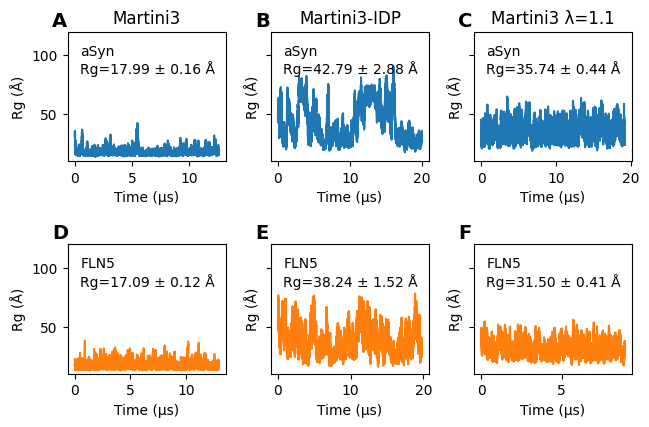

In [83]:
fig, ax = plt.subplots(2,3, figsize=(6.6,4.4), sharey=True)

# Matini3, Martini3-IDP, Martini3 lambda=1.1
# aSyn
files = ["D:/Documents/Zhao/MRes/Martini3/aSyn/md/277K/rgs.xvg",
         "D:/Documents/Zhao/MRes/Martini3/aSyn/md/277K_p/rgs.xvg",
         "D:/Documents/Zhao/MRes/Martini3/aSyn/md/277K_lambda1.1/rgs.xvg"]
block_size = [1000,1000,2500]
columns = ["Martini3", "Martini3-IDP", "Martini3 λ=1.1"]
data = np.loadtxt(files[0], skiprows=27)
time = data[:,0]
rg = data[:,1] * 10
mean, sem, nblocks = block_average(rg,1000)
ax[0,0].plot(time, rg, label=f"aSyn\nRg={mean:.2f} ± {sem:.2f} Å")
ax[0,0].legend(frameon=False, handlelength=0, handletextpad=0,loc='upper left',)
data = np.loadtxt(files[1], skiprows=27)
time = data[:200000,0]
rg = data[:200000,1] * 10
mean, sem, nblocks = block_average(rg,10000)
ax[0,1].plot(time, rg, label=f"aSyn\nRg={mean:.2f} ± {sem:.2f} Å")
ax[0,1].legend(frameon=False, handlelength=0, handletextpad=0,loc='upper left',)
data = np.loadtxt(files[2], skiprows=27)
time = data[:,0]
rg = data[:,1] * 10
mean, sem, nblocks = block_average(rg,2500)
ax[0,2].plot(time, rg, label=f"aSyn\nRg={mean:.2f} ± {sem:.2f} Å")
ax[0,2].legend(frameon=False, handlelength=0, handletextpad=0, loc='upper left',)
ax[0,0].set_ylim(top=120)
for i in range (3):
    ax[0,i].set_title(columns[i])

# FLN5
files = ["D:/Documents/Zhao/MRes/Martini3/FLN5/md/283K/rgs.xvg",
         "D:/Documents/Zhao/MRes/Martini3/FLN5/md/283K_p/rgs.xvg",
         "D:/Documents/Zhao/MRes/Martini3/FLN5/md/283K_lambda1.1/rgs.xvg"]
block_size = [2000, 7500, 2000]
for file, axis, bs in zip(files, ax[1,:], block_size):
    data = np.loadtxt(file, skiprows=27)
    time = data[:,0]
    rg = data[:,1] * 10
    mean, sem, nblocks = block_average(rg,bs)
    axis.plot(time, rg, color="C1", label=f"FLN5\nRg={mean:.2f} ± {sem:.2f} Å")
    axis.legend(frameon=False, handlelength=0, handletextpad=0,loc='upper left',)

for ax_panel, panel_label in zip(ax.flatten(), string.ascii_uppercase):
    ax_panel.set_xlabel("Time (µs)")
    ax_panel.set_ylabel("Rg (Å)")
    ax_panel.text(
        -0.1, 1.16,
        panel_label,
        transform=ax_panel.transAxes,
        fontsize=14,
        fontweight='bold',
        va='top',
        ha='left',
    )
    ax_panel.set_facecolor((0, 0, 0, 0))
fig.patch.set_alpha(0)            # Figure background
fig.tight_layout()

# Discussion

In [84]:
import MDAnalysis as mda
from MDAnalysis.analysis import helix_analysis as hel
from MDAnalysis.analysis import dssp
import matplotlib.pyplot as plt
import numpy as np

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [146]:
top_file = "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/folded/em_protein.pdb"
# trajs: unbiased unfolded, metad folding, opes_and_explore folding
# The unbiased traj samples every 0.1 ns, while others sample every 0.01 ns
trajs = ["D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/unfolded/fixed0.xtc",
         "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/folded/fit1_trimmed.xtc",
         "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational/conf0_1/run_c.xtc",
         "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/native_rational_opes_and_opes_explore/test/conf0_1/run_c.xtc"]
labels = ["Unbiased unfolded", "Unbiased folded", "WT-MetaD", "OPES + OPES explore"]

ref = mda.Universe(top_file)
residues = ref.select_atoms('protein').residues[:-1]  # drop final residue if needed
protein = residues.atoms
#dssp_analysis.run(start=0, stop=60000, step=1)
native_dssp = dssp.DSSP(protein).run()
#print(native_dssp.results.keys())
native_ss = native_dssp.results['dssp'][0]  # First (and only) frame
native_helix_mask = np.array([s in ['H', 'G', 'I'] for s in native_ss])
non_native_mask = ~native_helix_mask
print(native_helix_mask)

[False False  True  True  True  True  True  True  True  True  True False
 False False False False False False False False  True  True  True  True
  True  True  True  True  True False False False False False False  True
  True  True  True  True  True False False False False False False False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False False False  True  True  True  True False]


In [147]:
def helix_fractions(topology, trajectory, native_helix_mask, non_native_mask):
    u = mda.Universe(topology, trajectory)
    protein = u.select_atoms('protein').residues[:-1].atoms
    traj_dssp = dssp.DSSP(protein)
    traj_dssp.run()

    native_fractions = []
    non_native_fractions = []

    for ss in traj_dssp.results['dssp']:
        current_helix = np.array([s in ['H', 'G', 'I'] for s in ss])

        native_overlap = native_helix_mask & current_helix
        non_native_overlap = non_native_mask & current_helix

        # Avoid division by zero in case of pathological masks
        native_total = np.sum(native_helix_mask)
        non_native_total = np.sum(non_native_mask)

        native_fraction = np.sum(native_overlap) / native_total if native_total > 0 else 0.0
        non_native_fraction = np.sum(non_native_overlap) / non_native_total if non_native_total > 0 else 0.0

        native_fractions.append(native_fraction)
        non_native_fractions.append(non_native_fraction)

    return np.array(native_fractions), np.array(non_native_fractions)

In [148]:
results = []
for traj in trajs:
    nat, nonnat = helix_fractions(top_file, traj, native_helix_mask, non_native_mask)
    results.append((nat, nonnat))

In [154]:
np.savez("D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/helix_results.npz", *results)

In [155]:
loaded = np.load("D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/helix_results.npz", allow_pickle=True)
results_load = [tuple(x) for x in loaded.values()]
print(results_load)

[(array([0.13636364, 0.13636364, 0.06818182, ..., 0.22727273, 0.13636364,
       0.13636364]), array([0.        , 0.        , 0.        , ..., 0.        , 0.03571429,
       0.03571429])), (array([1.        , 0.86363636, 0.95454545, ..., 0.97727273, 0.88636364,
       0.88636364]), array([0.21428571, 0.10714286, 0.17857143, ..., 0.21428571, 0.21428571,
       0.21428571])), (array([0.25      , 0.18181818, 0.18181818, ..., 0.        , 0.        ,
       0.        ]), array([0.32142857, 0.28571429, 0.32142857, ..., 0.        , 0.        ,
       0.        ])), (array([0.25, 0.25, 0.25, ..., 0.  , 0.  , 0.  ]), array([0.32142857, 0.25      , 0.25      , ..., 0.        , 0.        ,
       0.10714286]))]


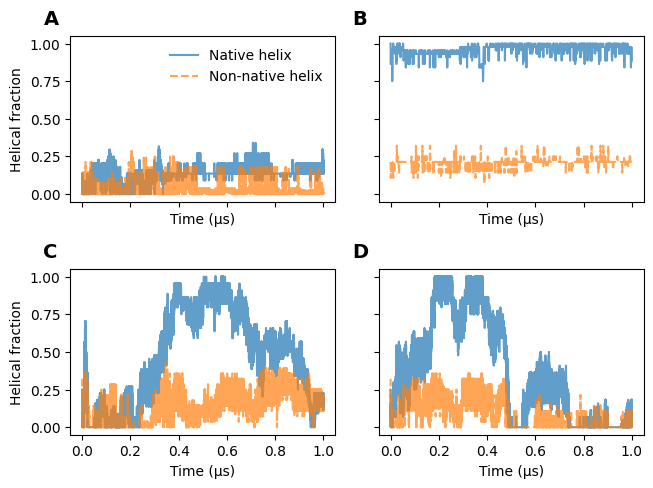

In [159]:
fig, ax = plt.subplots(2,2, figsize=(6.6,5), sharey=True, sharex=True)
n = [10000, 1000, 100000, 100000] # Normalizing factor for time

for i, axis in zip(range(4), ax.flatten()):
    nat, nonnat = results_load[i]
    nat = nat[:n[i]]
    nonnat = nonnat[:n[i]]
    time = np.arange(len(nat)) / n[i]
    axis.plot(time, nat, label=f"Native helix", alpha=0.7)
    axis.plot(time, nonnat, '--', label=f"Non-native helix", alpha=0.7)
    axis.set_xlabel("Time (µs)")
ax[0,0].set_ylabel("Helical fraction")
ax[0,0].legend(frameon=False)
ax[1,0].set_ylabel("Helical fraction")

for ax_panel, panel_label in zip(ax.flatten(), string.ascii_uppercase):
    ax_panel.text(
        -0.1, 1.16,
        panel_label,
        transform=ax_panel.transAxes,
        fontsize=14,
        fontweight='bold',
        va='top',
        ha='left',
    )
    ax_panel.set_facecolor((0, 0, 0, 0))
fig.patch.set_alpha(0)            # Figure background
fig.tight_layout()

# Folding pathway 2D

In [17]:
# Free energy calculation
file_1 = "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/bremd/unfolding/conf0_1/COLVAR_native_rational_N"
file_2 = "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/bremd/unfolding/conf0_1/COLVAR_native_rational_C"
file_bias = "D:/Documents/Zhao/MRes/Enhanced_sampling/HemK/md/bremd/unfolding/conf0_1/COLVAR.0"

fes_be_2D_0, bins_be_2D_0, bounds_be_2D_0, error_be_2D_0 = fes_2D(file_1, file_2, file_bias,
                                                                  "native", "native",
                                                                  range=None, bias=None, bandwidth=9.96434123156978)

(100, 100)


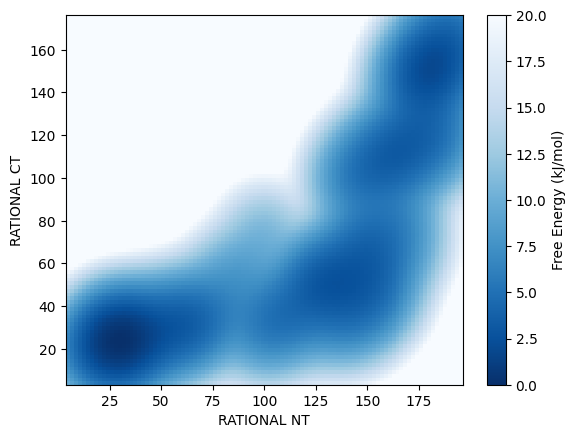

In [39]:
print(fes_be_2D_0.shape)
plt.imshow(fes_be_2D_0, origin='lower', 
           extent=[bounds_be_2D_0[0][0], bounds_be_2D_0[0][1],
                   bounds_be_2D_0[1][0], bounds_be_2D_0[1][1]],
           aspect='auto', cmap='Blues_r',
           vmax=20)
plt.xlabel('RATIONAL NT')
plt.ylabel('RATIONAL CT')
plt.colorbar(label='Free Energy (kJ/mol)')
#plt.title('2D Free Energy Surface')
plt.show()